In [1]:
import numpy as np
from tensorflow.keras import backend as K
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')
testImg = '/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images'
testMask = '/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask'
trainImg = '/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images'
trainMask = '/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask'
#these are the directories in which the images are present

Mounted at /content/drive


In [30]:
x_train = []
y_train = []
a = !ls '/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images'
b = !ls '/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask'
for i in a:
  x_train.append(cv.imread(trainImg + '/' + str(i.split()[0]))[:960,:960,:]/255)
  x_train.append(cv.imread(trainImg + '/' + str(i.split()[1]))[:960,:960,:]/255)

  y_train.append(cv.imread(trainMask + '/' + str(i.split()[0]),0)[:960,:960]/255)
  y_train.append(cv.imread(trainMask + '/' + str(i.split()[1]),0)[:960,:960]/255) 
  #I have corped the 1000x1000 image to 960x960 because in unet when i max pool th images 4 times 1000 becomes decimal
  #In have divided the images by 255 so that the pixel values are in the range [0,1]

Some train images and corresponding masks

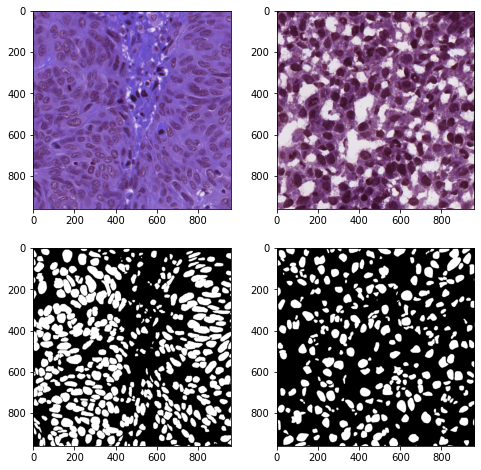

In [4]:
plt.figure(figsize = (8,8))
plt.subplot(221)
plt.imshow(x_train[0])
plt.subplot(222)
plt.imshow(x_train[1])
plt.subplot(223)
plt.imshow(y_train[0],cmap='gray')
plt.subplot(224)
plt.imshow(y_train[1],cmap='gray')

In [31]:
x_test = []
y_test = []
a = !ls '/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images'
b = !ls '/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask'
for i in a:
  x_test.append(cv.imread(testImg + '/' + str(i.split()[0]))[:960,:960,:]/255)
  x_test.append(cv.imread(testImg + '/' + str(i.split()[1]))[:960,:960,:]/255)

  y_test.append(cv.imread(testMask + '/' + str(i.split()[0]),0)[:960,:960]/255)
  y_test.append(cv.imread(testMask + '/' + str(i.split()[1]),0)[:960,:960]/255)

Some test images and corresponding masks

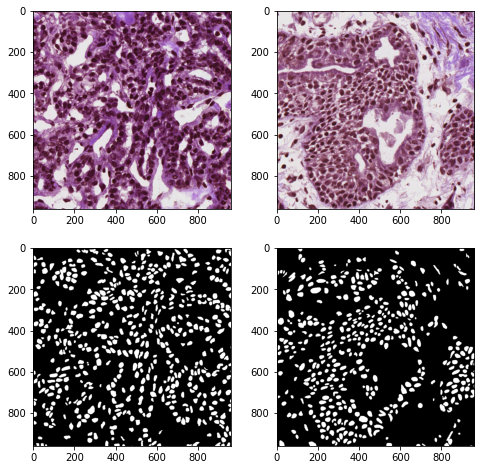

In [6]:
plt.figure(figsize = (8,8))
plt.subplot(221)
plt.imshow(x_test[0])
plt.subplot(222)
plt.imshow(x_test[1])
plt.subplot(223)
plt.imshow(y_test[0],cmap='gray')
plt.subplot(224)
plt.imshow(y_test[1],cmap='gray')

In [33]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
x_val = x_test[8:,:,:]
y_val = y_test[8:,:,:]
x_test = x_test[:7,:,:]
y_test = y_test[:7,:,:]
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
#The model takes only input tensor inputs(i.e similar to 4D array), so I have converted numpy arrays to tensors
#I have divided the test images into validation and test sets of 6 and 7 images respectively

The dice coefficient between images p and q is given by

$dice = \frac{2*p*q}{p^2+q^2}$ and loss is given by $1-dice$

In [10]:
def diceLoss(targets, inputs, smooth=1e-6):
  inputs = K.flatten(inputs) #tf.keras.backend.flatten convetrs 4D tensor to 1D array
  targets = K.flatten(targets)
  intersection = K.sum(targets*inputs)
  dice = (2*intersection + smooth)/(K.sum(targets) + K.sum(inputs) + smooth)
  return 1 - dice

UNET Model

In [11]:
def convAndPool(inputs, filters, kernal_size = (3,3), strides = 1, padding = "same"): #this is the function for convolving 'inputs' by 'filters' and maxpooling the convoluted image by 2x2 window
  x = Conv2D(filters, kernal_size, padding = padding, strides = strides, activation = "relu")(inputs)
  x = Conv2D(filters, kernal_size, padding = padding, strides = strides, activation = "relu")(x)
  p = MaxPool2D((2,2))(x)
  return x, p

In [12]:
def upConvAndConv(inputs, skip, filters, kernal_size = (3,3), strides = 1, padding = "same"): #this function unconvolutes the 'inputs' and does skip connection with 'skip'. Then it convoulves the concatenated image with 'filters'
  up = Conv2DTranspose(filters, (2,2), strides = 2, padding = "same")(inputs)
  c = Concatenate()([skip, up])
  y = Conv2D(filters, kernal_size, padding = padding, strides = strides, activation = "relu")(c)
  y = Conv2D(filters, kernal_size, padding = padding, strides = strides, activation = "relu")(y)
  return y

In [13]:
def unet(image_shape):
  inputs = Input(image_shape)

  p0 = inputs
  x1, p1 = convAndPool(p0, 64)   #downsampling
  x2, p2 = convAndPool(p1, 128)
  x3, p3 = convAndPool(p2, 256)
  x4, p4 = convAndPool(p3, 512)

  b = Conv2D(1024, (3,3), padding = "same", strides = 1, activation = "relu")(p4)
  b = Conv2D(1024, (3,3), padding = "same", strides = 1, activation = "relu")(b)

  y1 = upConvAndConv(b, x4, 512)  #upsampling
  y2 = upConvAndConv(y1, x3, 256)
  y3 = upConvAndConv(y2, x2, 128)
  y4 = upConvAndConv(y3, x1, 64)

  outputs = Conv2D(1, (1,1), padding = "same", strides = 1, activation = "sigmoid")(y4)
  model = Model(inputs, outputs)
  return model

In [14]:
model = unet((960,960,3)) #unet model with diceloss
model.compile('adam', loss = diceLoss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 960, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 960, 960, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 960, 960, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Using Diceloss

In [26]:
x_train[0].shape

TensorShape([960, 960, 3])

In [38]:
for i in range(30): #here I am trainging the model with x_train and y_train with batch-size of 1
  model.fit(tf.reshape(x_train[i], [1,960,960,3]), tf.reshape(y_train[i], [1,960,960,1]), epochs=5, verbose=1 )


Epoch 1/5
1/1 [==============================] - 1s 865ms/step - loss: 0.4285
Epoch 2/5
1/1 [==============================] - 1s 767ms/step - loss: 0.4285
Epoch 3/5
1/1 [==============================] - 1s 767ms/step - loss: 0.4285
Epoch 4/5
1/1 [==============================] - 1s 770ms/step - loss: 0.4285
Epoch 5/5
1/1 [==============================] - 1s 770ms/step - loss: 0.4285
Epoch 1/5
1/1 [==============================] - 1s 773ms/step - loss: 0.6034
Epoch 2/5
1/1 [==============================] - 1s 783ms/step - loss: 0.6034
Epoch 3/5
1/1 [==============================] - 1s 780ms/step - loss: 0.6034
Epoch 4/5
1/1 [==============================] - 1s 783ms/step - loss: 0.6034
Epoch 5/5
1/1 [==============================] - 1s 779ms/step - loss: 0.6034
Epoch 1/5
1/1 [==============================] - 1s 780ms/step - loss: 0.4689
Epoch 2/5
1/1 [==============================] - 1s 798ms/step - loss: 0.4689
Epoch 3/5
1/1 [==============================] - 1s 790ms/step -

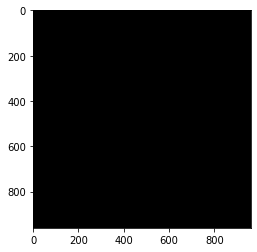

In [40]:
img = (model(tf.reshape(x_train[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.imshow((img*255).astype(np.uint8),cmap='gray')

Using dice-loss function the model is not learning as the loss value is not changing with changing epochs and also the output is not what is expected

Using MSE as loss function

In [51]:
model2 = unet((960,960,3)) #unet model with mean square error
model2.compile('adam', 'mse')
for i in range(30):
  model2.fit(tf.reshape(x_train[i], [1,960,960,3]), tf.reshape(y_train[i], [1,960,960,1]), epochs=3, verbose=1 )

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 0.2524
Epoch 2/3
1/1 [==============================] - 1s 833ms/step - loss: 0.2450
Epoch 3/3
1/1 [==============================] - 1s 831ms/step - loss: 0.2379
Epoch 1/3
1/1 [==============================] - 1s 830ms/step - loss: 0.1751
Epoch 2/3
1/1 [==============================] - 1s 848ms/step - loss: 0.1743
Epoch 3/3
1/1 [==============================] - 1s 844ms/step - loss: 0.1481
Epoch 1/3
1/1 [==============================] - 1s 829ms/step - loss: 0.1977
Epoch 2/3
1/1 [==============================] - 1s 844ms/step - loss: 0.1962
Epoch 3/3
1/1 [==============================] - 1s 842ms/step - loss: 0.1937
Epoch 1/3
1/1 [==============================] - 1s 828ms/step - loss: 0.1327
Epoch 2/3
1/1 [==============================] - 1s 848ms/step - loss: 0.1320
Epoch 3/3
1/1 [==============================] - 1s 849ms/step - loss: 0.1304
Epoch 1/3
1/1 [==============================] - 1s 838ms/step - lo

We can see error decreasing with each epoch and thus the model is learning

Validation and Test errors

In [63]:
print('Validation errors')
for i in range(6):
  print(np.mean(((model2(tf.reshape(x_val[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_val[i])**2))

Validation errors
0.11279034153343072
0.2725084233954973
0.32248751783680407
0.3186849866601531
0.32189078970786555
0.30049104914507646


In [61]:
print('Test errors')
for i in range(7):
  print(np.mean(((model2(tf.reshape(x_test[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_test[i])**2))

Test errors
0.16117760948373425
0.36275455061242357
0.39700491244467767
0.38094176108161276
0.3769431789276104
0.3720512284106511
0.36755014475727976


We can see that errors of validation and test images is greater than those of train images, still the errors are less than 0.5

Output maps

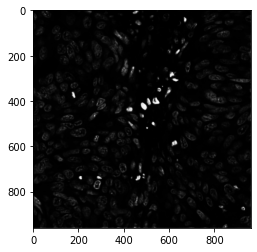

In [55]:
img = (model2(tf.reshape(x_train[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.imshow((img*255).astype(np.uint8),cmap='gray')

The output map is good but the pixel values of the mask have very low value, applying gamma transform can make the result better 

Text(0.5, 1.0, 'target mask')

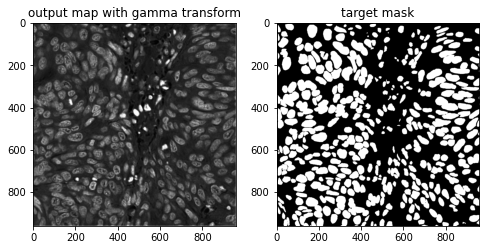

In [70]:
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform')
plt.subplot(122)
plt.imshow(y_train[0,:,:,0],cmap='gray')
plt.title('target mask')

Text(0.5, 1.0, 'target mask')

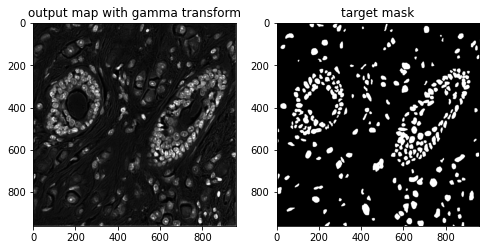

In [71]:
img2 = (model2(tf.reshape(x_train[5], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img2**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform')
plt.subplot(122)
plt.imshow(y_train[5,:,:,0],cmap='gray')
plt.title('target mask')

Output maps for test images

Text(0.5, 1.0, 'target mask')

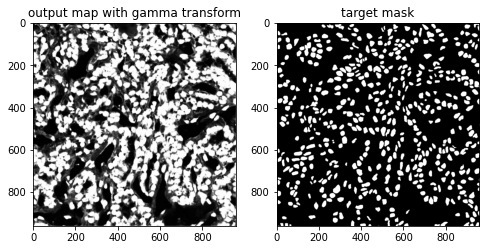

In [76]:
img3 = (model2(tf.reshape(x_test[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img3**0.5)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform')
plt.subplot(122)
plt.imshow(y_test[0],cmap='gray')
plt.title('target mask')

Text(0.5, 1.0, 'target mask')

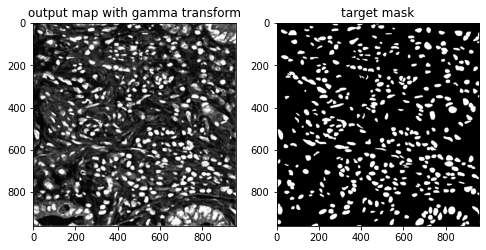

In [85]:
img4 = (model2(tf.reshape(x_test[6], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img4**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform')
plt.subplot(122)
plt.imshow(y_test[6],cmap='gray')
plt.title('target mask')

The output masks for test images are not as good as those for train images. So, this may be because our training set small

Modifying baseline architecture

a)Decreasing number of blocks by 1

In [79]:
def unet2(image_shape):
  inputs = Input(image_shape)

  p0 = inputs
  x1, p1 = convAndPool(p0, 64)
  x2, p2 = convAndPool(p1, 128)
  x3, p3 = convAndPool(p2, 256)

  b = Conv2D(1024, (3,3), padding = "same", strides = 1, activation = "relu")(p3)
  b = Conv2D(1024, (3,3), padding = "same", strides = 1, activation = "relu")(b)

  y2 = upConvAndConv(b, x3, 256)
  y3 = upConvAndConv(y2, x2, 128)
  y4 = upConvAndConv(y3, x1, 64)

  outputs = Conv2D(1, (1,1), padding = "same", strides = 1, activation = "sigmoid")(y4)
  model = Model(inputs, outputs)
  return model

In [80]:
model3 = unet2((960,960,3))
model3.compile('adam', 'mse')
for i in range(30):
  model3.fit(tf.reshape(x_train[i], [1,960,960,3]), tf.reshape(y_train[i], [1,960,960,1]), epochs=3, verbose=1 )

Epoch 1/3
1/1 [==============================] - 19s 19s/step - loss: 0.2534
Epoch 2/3
1/1 [==============================] - 1s 762ms/step - loss: 0.2469
Epoch 3/3
1/1 [==============================] - 1s 775ms/step - loss: 0.2420
Epoch 1/3
1/1 [==============================] - 1s 761ms/step - loss: 0.2021
Epoch 2/3
1/1 [==============================] - 1s 769ms/step - loss: 0.1531
Epoch 3/3
1/1 [==============================] - 1s 763ms/step - loss: 0.2438
Epoch 1/3
1/1 [==============================] - 1s 755ms/step - loss: 0.3471
Epoch 2/3
1/1 [==============================] - 1s 764ms/step - loss: 0.2537
Epoch 3/3
1/1 [==============================] - 1s 762ms/step - loss: 0.1971
Epoch 1/3
1/1 [==============================] - 1s 761ms/step - loss: 0.1368
Epoch 2/3
1/1 [==============================] - 1s 766ms/step - loss: 0.1442
Epoch 3/3
1/1 [==============================] - 1s 757ms/step - loss: 0.1408
Epoch 1/3
1/1 [==============================] - 1s 760ms/step - 

Text(0.5, 1.0, 'target mask')

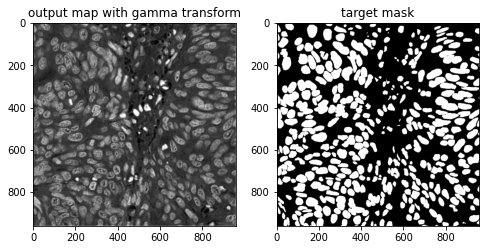

In [81]:
img5 = (model3(tf.reshape(x_train[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img5**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform')
plt.subplot(122)
plt.imshow(y_train[0,:,:,0],cmap='gray')
plt.title('target mask')

The validation and test errors are as below

In [82]:
print('Validation errors')
for i in range(6):
  print(np.mean(((model3(tf.reshape(x_val[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_val[i])**2))

Validation errors
0.11700586363745008
0.2680615903867076
0.3115202911483554
0.30754432665337134
0.31076476514046464
0.2909901745073981


In [83]:
print('Test errors')
for i in range(7):
  print(np.mean(((model3(tf.reshape(x_test[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_test[i])**2))

Test errors
0.13344773237599242
0.32469181733764374
0.36445579835763714
0.34590132511850324
0.34133149475955976
0.33667715287209243
0.3285711961026019


Text(0.5, 1.0, 'target mask')

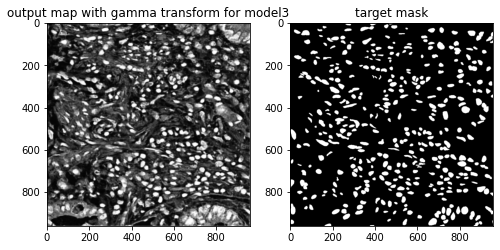

In [84]:
img5 = (model3(tf.reshape(x_test[6], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img5**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model3')
plt.subplot(122)
plt.imshow(y_test[6],cmap='gray')
plt.title('target mask')

By decreasing the blocks by one doesen't effect the performance of the model much.

b) Decreasing number of blocks by 2

In [86]:
def unet3(image_shape):
  inputs = Input(image_shape)

  p0 = inputs
  x1, p1 = convAndPool(p0, 64)
  x2, p2 = convAndPool(p1, 128)

  b = Conv2D(1024, (3,3), padding = "same", strides = 1, activation = "relu")(p2)
  b = Conv2D(1024, (3,3), padding = "same", strides = 1, activation = "relu")(b)

  y3 = upConvAndConv(b, x2, 128)
  y4 = upConvAndConv(y3, x1, 64)

  outputs = Conv2D(1, (1,1), padding = "same", strides = 1, activation = "sigmoid")(y4)
  model = Model(inputs, outputs)
  return model

In [88]:
model4 = unet3((960,960,3))
model4.compile('adam', 'mse')
for i in range(30):
  model4.fit(tf.reshape(x_train[i], [1,960,960,3]), tf.reshape(y_train[i], [1,960,960,1]), epochs=3, verbose=1 )

Epoch 1/3
1/1 [==============================] - 14s 14s/step - loss: 0.2463
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.2330
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.2335
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 0.1702
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.1553
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.1440
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 0.1971
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.1961
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.1884
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 0.1359
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 0.1279
Epoch 3/3
1/1 [==============================] - 1s 1s/step - loss: 0.1331
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 0.1803
Epoch 2/3
1/1 [========

Text(0.5, 1.0, 'target mask')

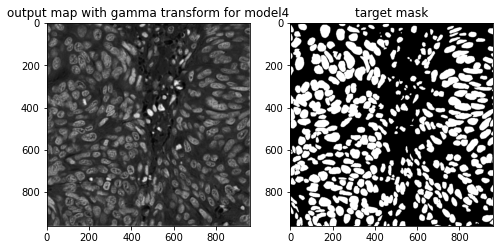

In [89]:
img6 = (model4(tf.reshape(x_train[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img6**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model4')
plt.subplot(122)
plt.imshow(y_train[0,:,:,0],cmap='gray')
plt.title('target mask')

In [90]:
print('Validation errors')
for i in range(6):
  print(np.mean(((model4(tf.reshape(x_val[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_val[i])**2))

Validation errors
0.10618962267014824
0.15291631250108523
0.23407771429144913
0.22652011290710766
0.23336006527207515
0.20730128379928023


In [91]:
print('Test errors')
for i in range(7):
  print(np.mean(((model4(tf.reshape(x_test[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_test[i])**2))

Test errors
0.079394488566033
0.2429693195716337
0.3058098292404489
0.2771859474738961
0.2692840044526699
0.2628142258675335
0.24532735525180896


We can observe that validation and test errors have reduced very compared to the original unet. This is because as we have reduced the number of blocks in the unet we reduce overfitting of train data

Text(0.5, 1.0, 'target mask')

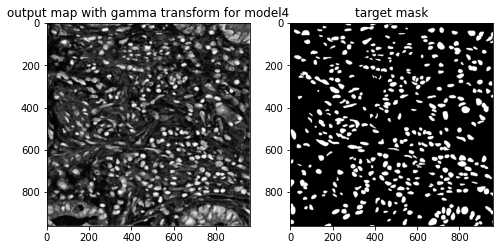

In [92]:
img7 = (model4(tf.reshape(x_test[6], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img7**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model4')
plt.subplot(122)
plt.imshow(y_test[6],cmap='gray')
plt.title('target mask')

The output map for a test image is better than that of original unet

c) Decreasing number of filters by 2 times

In [93]:
def unet4(image_shape):
  inputs = Input(image_shape)

  p0 = inputs
  x1, p1 = convAndPool(p0, 32)
  x2, p2 = convAndPool(p1, 64)
  x3, p3 = convAndPool(p2, 128)
  x4, p4 = convAndPool(p3, 256)

  b = Conv2D(512, (3,3), padding = "same", strides = 1, activation = "relu")(p4)
  b = Conv2D(512, (3,3), padding = "same", strides = 1, activation = "relu")(b)

  y1 = upConvAndConv(b, x4, 256)
  y2 = upConvAndConv(y1, x3, 128)
  y3 = upConvAndConv(y2, x2, 64)
  y4 = upConvAndConv(y3, x1, 32)

  outputs = Conv2D(1, (1,1), padding = "same", strides = 1, activation = "sigmoid")(y4)
  model = Model(inputs, outputs)
  return model

In [100]:
model5 = unet4((960,960,3))
model5.compile('adam', 'mse')
for i in range(30):
  model5.fit(tf.reshape(x_train[i], [1,960,960,3]), tf.reshape(y_train[i], [1,960,960,1]), epochs=3, verbose=1 )

Epoch 1/3
1/1 [==============================] - 8s 8s/step - loss: 0.2524
Epoch 2/3
1/1 [==============================] - 0s 312ms/step - loss: 0.2456
Epoch 3/3
1/1 [==============================] - 0s 296ms/step - loss: 0.2392
Epoch 1/3
1/1 [==============================] - 0s 378ms/step - loss: 0.2002
Epoch 2/3
1/1 [==============================] - 0s 298ms/step - loss: 0.1737
Epoch 3/3
1/1 [==============================] - 0s 302ms/step - loss: 0.1485
Epoch 1/3
1/1 [==============================] - 0s 315ms/step - loss: 0.2436
Epoch 2/3
1/1 [==============================] - 0s 302ms/step - loss: 0.2094
Epoch 3/3
1/1 [==============================] - 0s 323ms/step - loss: 0.1947
Epoch 1/3
1/1 [==============================] - 0s 314ms/step - loss: 0.1332
Epoch 2/3
1/1 [==============================] - 0s 301ms/step - loss: 0.1328
Epoch 3/3
1/1 [==============================] - 0s 323ms/step - loss: 0.1331
Epoch 1/3
1/1 [==============================] - 0s 315ms/step - lo

Text(0.5, 1.0, 'target mask')

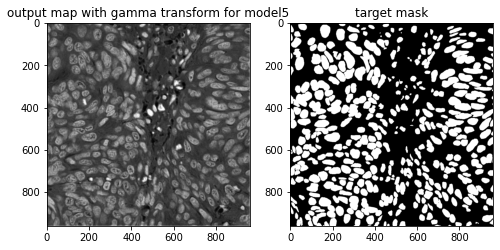

In [109]:
img8 = (model5(tf.reshape(x_train[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img8**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model5')
plt.subplot(122)
plt.imshow(y_train[0,:,:,0],cmap='gray')
plt.title('target mask')

In [102]:
print('Validation errors')
for i in range(6):
  print(np.mean(((model5(tf.reshape(x_val[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_val[i])**2))

Validation errors
0.1011165427553099
0.176018664819041
0.24540835913819592
0.23846494821411068
0.24483433680908523
0.2206511271548258


In [103]:
print('Test errors')
for i in range(7):
  print(np.mean(((model5(tf.reshape(x_test[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_test[i])**2))

Test errors
0.08792364970564892
0.23760460491012947
0.29697136322733225
0.26941487426542493
0.2625506341634378
0.25597397765859475
0.23941890141118022


Text(0.5, 1.0, 'target mask')

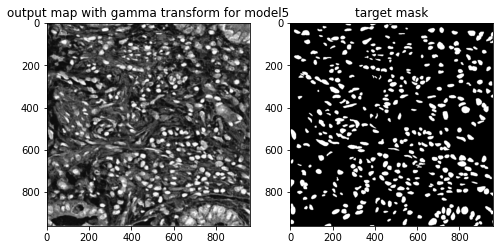

In [115]:
img9 = (model5(tf.reshape(x_test[6], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img9**0.3)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model5')
plt.subplot(122)
plt.imshow(y_test[6],cmap='gray')
plt.title('target mask')

d) Increasing number of filters by 2 times

In [105]:
def unet5(image_shape):
  inputs = Input(image_shape)

  p0 = inputs
  x1, p1 = convAndPool(p0, 128)
  x2, p2 = convAndPool(p1, 256)
  x3, p3 = convAndPool(p2, 512)
  x4, p4 = convAndPool(p3, 1024)

  b = Conv2D(2048, (3,3), padding = "same", strides = 1, activation = "relu")(p4)
  b = Conv2D(2048, (3,3), padding = "same", strides = 1, activation = "relu")(b)

  y1 = upConvAndConv(b, x4, 1024)
  y2 = upConvAndConv(y1, x3, 512)
  y3 = upConvAndConv(y2, x2, 256)
  y4 = upConvAndConv(y3, x1, 128)

  outputs = Conv2D(1, (1,1), padding = "same", strides = 1, activation = "sigmoid")(y4)
  model = Model(inputs, outputs)
  return model

In [106]:
model6 = unet5((960,960,3))
model6.compile('adam', 'mse')
for i in range(30):
  model5.fit(tf.reshape(x_train[i], [1,960,960,3]), tf.reshape(y_train[i], [1,960,960,1]), epochs=3, verbose=1 )

Epoch 1/3
1/1 [==============================] - 0s 403ms/step - loss: 0.3323
Epoch 2/3
1/1 [==============================] - 0s 286ms/step - loss: 0.3178
Epoch 3/3
1/1 [==============================] - 0s 291ms/step - loss: 0.2939
Epoch 1/3
1/1 [==============================] - 0s 308ms/step - loss: 0.0823
Epoch 2/3
1/1 [==============================] - 0s 296ms/step - loss: 0.0994
Epoch 3/3
1/1 [==============================] - 0s 291ms/step - loss: 0.1041
Epoch 1/3
1/1 [==============================] - 0s 305ms/step - loss: 0.1869
Epoch 2/3
1/1 [==============================] - 0s 292ms/step - loss: 0.1557
Epoch 3/3
1/1 [==============================] - 0s 298ms/step - loss: 0.1272
Epoch 1/3
1/1 [==============================] - 0s 310ms/step - loss: 0.1367
Epoch 2/3
1/1 [==============================] - 0s 291ms/step - loss: 0.1347
Epoch 3/3
1/1 [==============================] - 0s 298ms/step - loss: 0.1373
Epoch 1/3
1/1 [==============================] - 0s 304ms/step -

Text(0.5, 1.0, 'target mask')

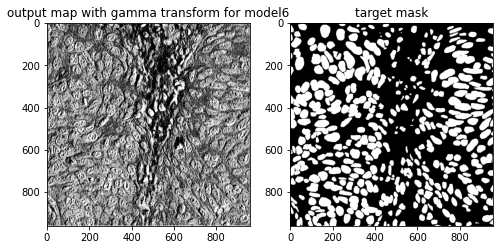

In [116]:
img9 = (model6(tf.reshape(x_train[0], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img9**0.2)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model6')
plt.subplot(122)
plt.imshow(y_train[0,:,:,0],cmap='gray')
plt.title('target mask')

In [110]:
print('Validation errors')
for i in range(6):
  print(np.mean(((model6(tf.reshape(x_val[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_val[i])**2))

Validation errors
0.2506803324118415
0.2510835242380314
0.25069691925790555
0.25075022610508246
0.25069875416813914
0.2508043712899066


In [111]:
print('Test errors')
for i in range(7):
  print(np.mean(((model6(tf.reshape(x_test[0], [1,960,960,3]))[0].numpy())[:,:,0] - y_test[i])**2))

Test errors
0.25159730242143424
0.25145030791546413
0.25091299832253805
0.2511730106606183
0.25122325418922986
0.25128365105702116
0.2514684622762449


Text(0.5, 1.0, 'target mask')

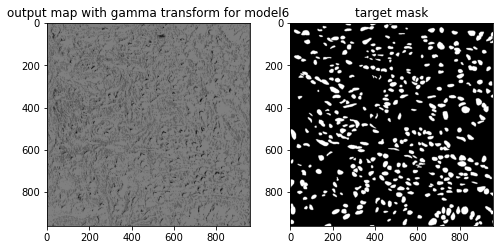

In [114]:
img10 = (model6(tf.reshape(x_test[6], [1,960,960,3]))[0].numpy())[:,:,0]
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(((img10**0.2)*255).astype(np.uint8),cmap='gray')
plt.title('output map with gamma transform for model6')
plt.subplot(122)
plt.imshow(y_test[6],cmap='gray')
plt.title('target mask')

Increasing number of filters does not give good results compared to original results

**Acknowledgement:**  DiceLoss function code was taken form kaggle and for the remaining codes I have reffered tensorflow official documentation. The unet code was inspired by code in https://www.youtube.com/watch?v=M3EZS__Z_XE&t=325s

I have done the assignment till Q5b